# **Modeling with a Neural Network**

## Part 1: Data Preparation

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
data=pd.read_csv('Crime_Clean2.csv')

In [4]:
len(data)

235368

In [5]:
data = data[data['Crime Name1'] != 'Other']
data = data[~(data['Crime Name1'].isnull())]

In [6]:
data['Crime Name1'].value_counts()

Crime Against Property    103669
Crime Against Society      59437
Crime Against Person       21904
Not a Crime                 2817
Name: Crime Name1, dtype: int64

In [7]:
data=data[data['Crime Name1'] != 'Not a Crime']

In [8]:
data['Crime Name1'].value_counts()

Crime Against Property    103669
Crime Against Society      59437
Crime Against Person       21904
Name: Crime Name1, dtype: int64

In [9]:
data['Place'].value_counts()

Street - In vehicle            27246
Residence - Single Family      13871
Street - Residential           13804
Residence - Apartment/Condo    13445
Other/Unknown                  11900
                               ...  
Pawn Shop                         42
Retail - Video Store              30
Nursery                           15
Lake/Waterway                     13
Pedestrian Tunnel                  9
Name: Place, Length: 83, dtype: int64

In [10]:
## Create new, less general crime categories based on EDA rather than NIBRS crime classifications

import re

pattern1 = r'.*\s*(ASSAULT|RAPE|BLDG|OBSTRUCT GOVT|SEX|FAMILY|FORCED|COMMUNICATION|TRESPASSING|LARCENY \(DESCRIBE OFFENSE\))\.*'
pattern2 = r'.*\s*(DRUGS|INFLUENCE|LIQUOR|OBSTRUCT POLICE|WEAPON)\.*'
pattern3 = r'.*\s*(FRAUD|IDENTITY|FORGERY|EMBEZZLE)\.*'
pattern4 = r'.*\s*(DAMAGE PROPERTY|AUTO|DISORDERLY CONDUCT|ROBBERY)\.*'
pattern5 = r'.*\s*(SHOPLIFTING|MALLS|POCKET|PURSE|COUNTERFEITING)\.*'

for i, rowseries in data.iterrows():
    if re.match(pattern1, data.at[i,'Crime Name3']):
        data.at[i, 'Crime Type'] = 'Assault/Burglary/Residential Theft'
    elif re.match(pattern2, data.at[i,'Crime Name3']):
        data.at[i,'Crime Type'] = 'Drugs/DUI/Weapon'
    elif re.match(pattern3, data.at[i,'Crime Name3']):
        data.at[i,'Crime Type'] = 'Fraud'
    elif re.match(pattern4, data.at[i,'Crime Name3']):
        data.at[i,'Crime Type'] = 'Auto Theft/Property Damage/Robbery/Disorderly Conduct'
    elif re.match(pattern5, data.at[i,'Crime Name3']):
        data.at[i,'Crime Type'] = 'Theft from Store/Pocket Picking/Counterfeit'
    else:
        data.at[i,'Crime Type'] = 'All Other Offenses'

In [11]:
data['Crime Type'].value_counts()

Assault/Burglary/Residential Theft                       53424
Auto Theft/Property Damage/Robbery/Disorderly Conduct    50067
Drugs/DUI/Weapon                                         44788
Fraud                                                    16871
Theft from Store/Pocket Picking/Counterfeit              13932
All Other Offenses                                        5928
Name: Crime Type, dtype: int64

In [12]:
data = data[data['Crime Type'] != 'All Other Offenses']
data['Crime Type'].value_counts()

Assault/Burglary/Residential Theft                       53424
Auto Theft/Property Damage/Robbery/Disorderly Conduct    50067
Drugs/DUI/Weapon                                         44788
Fraud                                                    16871
Theft from Store/Pocket Picking/Counterfeit              13932
Name: Crime Type, dtype: int64

In [13]:
classes = data['Crime Type'].value_counts()

top_classes = list(classes.index.values)

top_classes = sorted(top_classes)
top_classes

['Assault/Burglary/Residential Theft',
 'Auto Theft/Property Damage/Robbery/Disorderly Conduct',
 'Drugs/DUI/Weapon',
 'Fraud',
 'Theft from Store/Pocket Picking/Counterfeit']

In [14]:
len(data)

179082

In [15]:
## Label Encode the target variable 
data['target'] = data['Crime Type'].astype('category').cat.codes

In [16]:
## Create a column that gives the number of words for each place corresponding to each crime
data['num_words'] = data['Place'].apply(lambda x: len(x.split()))

In [17]:
## Create variable that categorizes or bins the number of words for each crime
data['bins'] = pd.cut(data['num_words'], bins=[0,5,10,15,20], labels=['0-5','5-10','10-15','15-20'])

In [18]:
## Group the data by bin counts
word_dist = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [19]:
word_dist.head()

,bins,counts
0,0-5,178473
1,5-10,609
2,10-15,0
3,15-20,0


In [20]:
num_class = len(np.unique(data['target'].values))
y = data['target'].values

In [21]:
num_class

5

In [22]:
y

array([0, 0, 0, ..., 2, 2, 1], dtype=int8)

In [23]:
# Fit a tokenizer to the place variable to tokenize the Place variable such that a word embedding space can be 
# constructed from it

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len=10
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Place'].values)
post_seq = tokenizer.texts_to_sequences(data['Place'].values)
post_seq_padded = pad_sequences(post_seq,maxlen=max_len)

In [24]:
post_seq_padded[0]

array([ 0,  0,  0,  0,  0,  0,  0,  2, 11, 12], dtype=int32)

In [25]:
post_seq_padded[2]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  7, 15], dtype=int32)

In [26]:
post_seq_padded.shape

(179082, 10)

In [27]:
features = data[['Income','Pop','Public Transportation %','High School %', 'Bachelors %', 'Age', 'Unemployed %', 'Victims','Black %', 'White %']]

In [28]:
features = np.array(features)

In [29]:
features.shape

(179082, 10)

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

features = scaler.fit_transform(features)

In [31]:
from sklearn.model_selection import train_test_split

x_train_place, x_test_place, y_train_place, y_test_place = train_test_split(post_seq_padded,y,test_size=0.25,random_state=4)
x_train_other, x_test_other, y_train_other, y_test_other = train_test_split(features,y,test_size=0.25,random_state=4)

In [32]:
## Number of words in Place variabel

vocab_size= len(tokenizer.word_index) + 1

In [33]:
## Create a multi-input model that takes the tokenize place variable as one input and the numerical variables as a separate input.
## Create an embedding layer and train it to learn word embeddings using an recurrent neural network.

from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Concatenate
from tensorflow.keras.models import Sequential, Model

inputs1 = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, 256, input_length=max_len)(inputs1)
x1 = LSTM(128)(embedding_layer)
x2 = Dense(64, activation='relu')(x1)

inputs2 = Input(shape=(10,))
layer2 = Dense(128,activation='relu')(inputs2)
layer3 = Dense(64,activation='relu')(layer2)

concat = Concatenate()([x2, layer3])

preds = Dense(num_class, activation = 'softmax')(concat)

model = Model(inputs=[inputs1,inputs2], outputs=preds)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])


In [34]:
## One-hot encode the target variable for classification metrics
y= tf.keras.utils.to_categorical(y_train_place)

In [35]:
len(x_train_place)

134311

In [36]:
len(x_test_place)

44771

In [37]:
history = model.fit([x_train_place, x_train_other],y, batch_size=128, verbose=1, validation_split=0.25,shuffle=True, epochs=10)

Epoch 1/10
787/787 [==============================] - 8s 11ms/step - loss: 0.8880 - acc: 0.6785 - val_loss: 0.8608 - val_acc: 0.6890
Epoch 2/10
787/787 [==============================] - 8s 10ms/step - loss: 0.8514 - acc: 0.6924 - val_loss: 0.8432 - val_acc: 0.6951
Epoch 3/10
787/787 [==============================] - 8s 10ms/step - loss: 0.8405 - acc: 0.6962 - val_loss: 0.8335 - val_acc: 0.6972
Epoch 4/10
787/787 [==============================] - 8s 10ms/step - loss: 0.8363 - acc: 0.6969 - val_loss: 0.8354 - val_acc: 0.6978
Epoch 5/10
787/787 [==============================] - 8s 10ms/step - loss: 0.8351 - acc: 0.6969 - val_loss: 0.8316 - val_acc: 0.6978
Epoch 6/10
787/787 [==============================] - 8s 10ms/step - loss: 0.8337 - acc: 0.6970 - val_loss: 0.8378 - val_acc: 0.6969
Epoch 7/10
787/787 [==============================] - 8s 10ms/step - loss: 0.8326 - acc: 0.6972 - val_loss: 0.8337 - val_acc: 0.6994
Epoch 8/10
787/787 [==============================] - 8s 10ms/step - 

In [38]:
predictions = model.predict([x_test_place,x_test_other])

In [39]:
y_test_place = tf.keras.utils.to_categorical(y_test_place)

In [40]:
loss, acc = model.evaluate([x_test_place, x_test_other], y_test_place)

1400/1400 [==============================] - 6s 4ms/step - loss: 0.8345 - acc: 0.6942


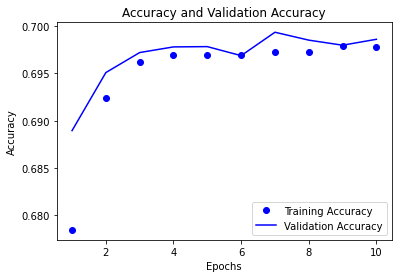

In [41]:
import matplotlib.pyplot as plt

acc= history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc,'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy and Validation Accuracy')
plt.show()

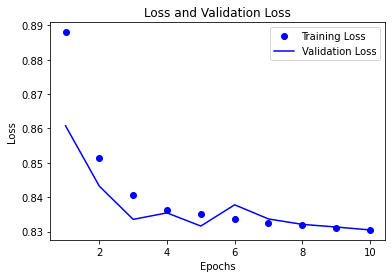

In [42]:
plt.clf()

plt.plot(epochs, loss,'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss and Validation Loss')
plt.show()

In [43]:
predictions[:,1]

array([0.53407675, 0.12349617, 0.7375362 , ..., 0.23512723, 0.6850059 ,
       0.06273246], dtype=float32)

In [44]:
predictions[:,2]

array([0.25457558, 0.07066798, 0.17441486, ..., 0.60186267, 0.23290694,
       0.90065277], dtype=float32)

In [45]:
y_test_place[:,1]

array([1., 0., 1., ..., 0., 1., 0.], dtype=float32)

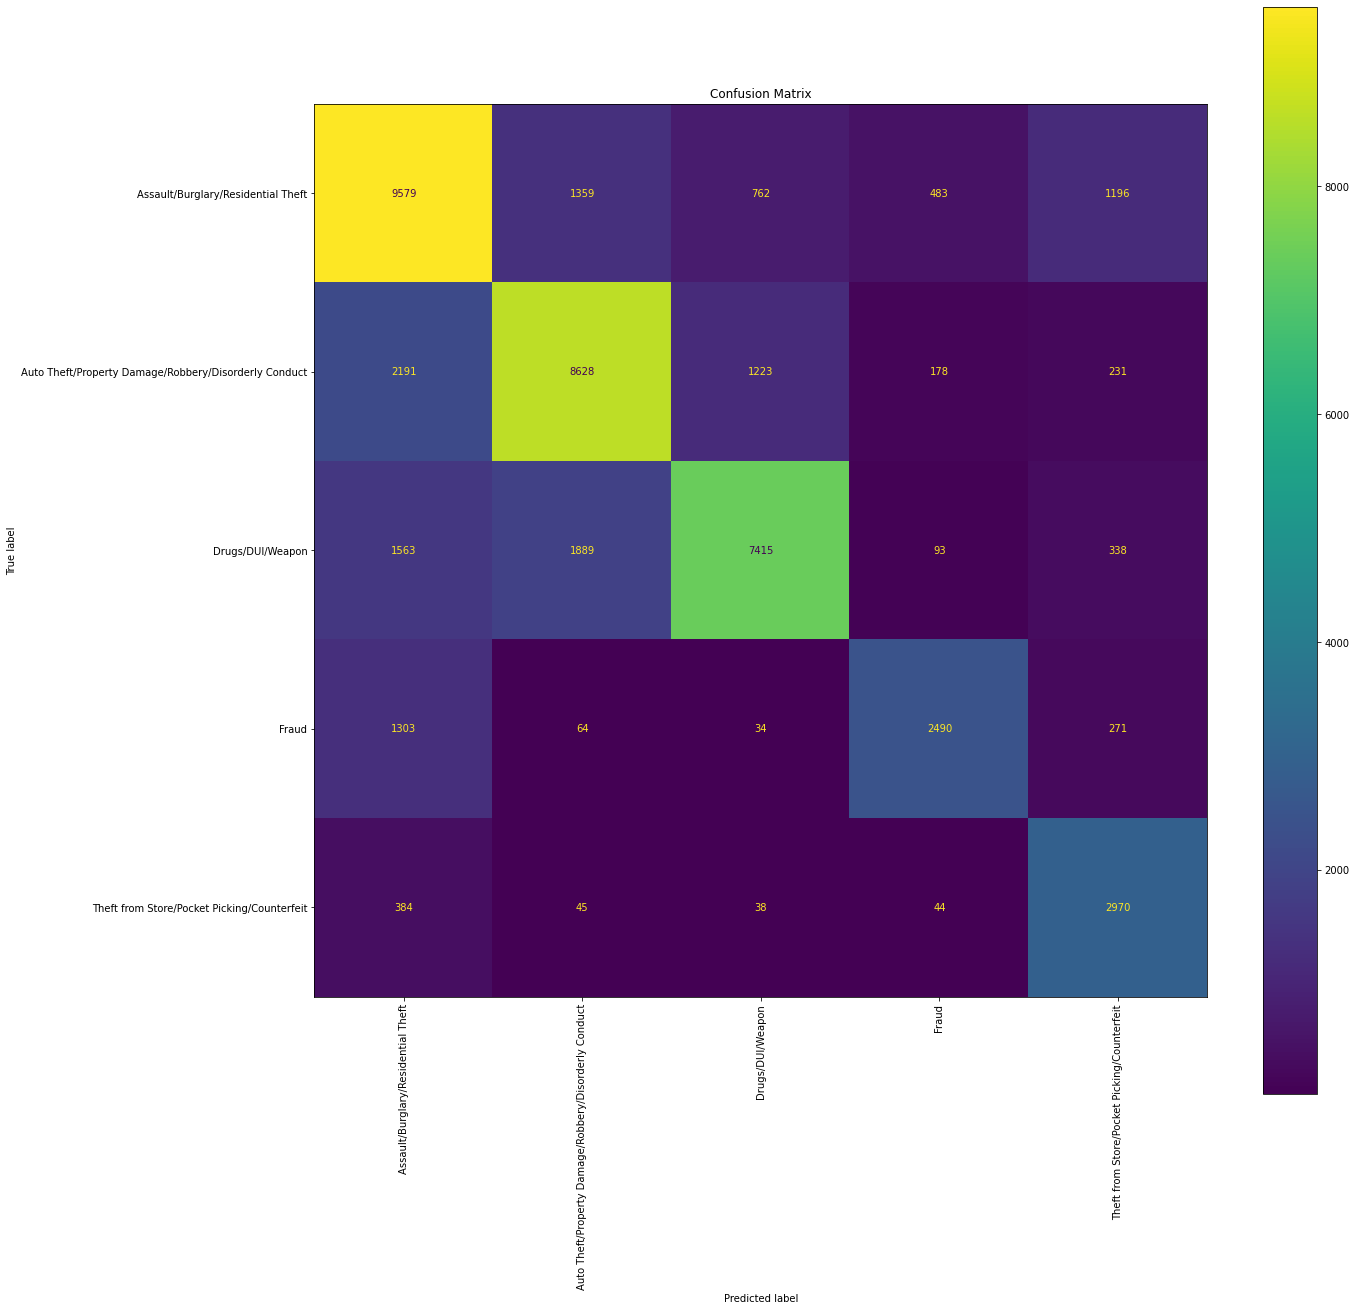

In [46]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_other, np.argmax(predictions,axis=1))

disp = ConfusionMatrixDisplay(cm, display_labels=top_classes)

disp = disp.plot()
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches(20,20)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


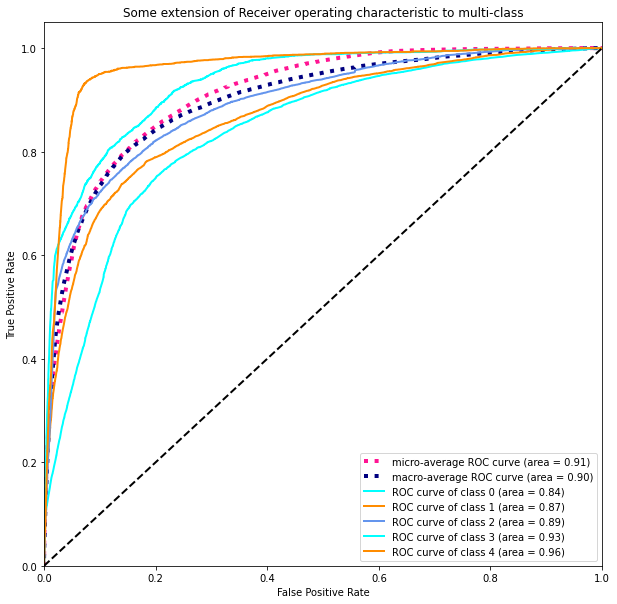

In [47]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(top_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_place[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_place.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(top_classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(top_classes)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(top_classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(top_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()



In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(top_classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_place[:, i],
                                                        predictions[:, i])
    average_precision[i] = average_precision_score(y_test_place[:, i], predictions[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_place.ravel(),
    predictions.ravel())
average_precision["micro"] = average_precision_score(y_test_place, predictions,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.75


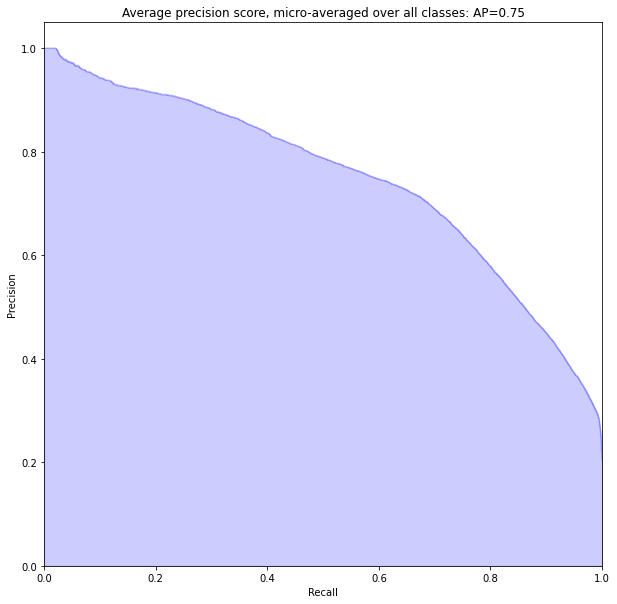

In [49]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
fig = plt.gcf()
fig.set_size_inches(10,10)

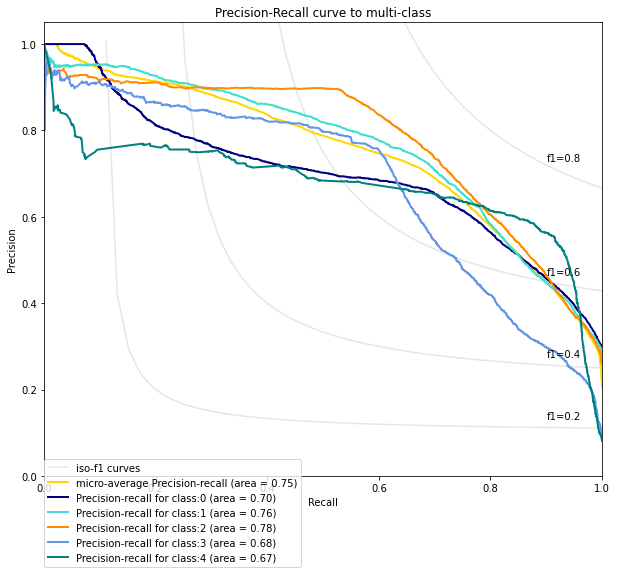

In [50]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(14, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(len(top_classes)), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.show()

In [51]:
from sklearn.metrics import roc_auc_score

macro_roc_auc_ovo = roc_auc_score(y_test_place, predictions, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test_place, predictions, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test_place, predictions, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test_place, predictions, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.899315 (macro),
0.879540 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.899315 (macro),
0.879540 (weighted by prevalence)
